# Purpose

- Used to visualise HDF5 files from MCMC analysis
- Developed to handle output files from MCMC.py and MCMC2.py
- Produces plots for walkers
- Produces corner plot
- Produces more detailed analysis for the best fit parameters

In [41]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import corner
import emcee
import json

from zdm import survey
from zdm import cosmology as cos
from zdm import loading as loading
import zdm.misc_functions as mf
import zdm.iteration as it
from zdm import parameters
from zdm.MCMC import calc_log_posterior
from astropy.cosmology import Planck18

plt.rcParams['font.size'] = 10

# Load files

- labels = list of parameters (in order)
- filenames = list of .h5 files to use (without .h5 extension)

In [ ]:
labels = ["sfr_n", "alpha", "lmean", "lsigma", "lEmax", "lEmin", "gamma", "H0", "DMhalo"]
# labels = [r"$n$", r"$\alpha$", r"log$\mu$", r"log$\sigma$", r"log$E_{\mathrm{max}}$", r"log$E_{\mathrm{min}}$", r"$\gamma$", r"$H_0$", "DMhalo"]
filenames = ['../mcmc/halo_new_full_5']

# labels = ["sfr_n", "alpha", "lmean", "lsigma", "lEmax", "lEmin", "gamma", "H0"]
# filenames = ['../mcmc/no_halo']

# labels = ["lRmin", "lRmax", "Rgamma"]
# filenames = ['../mcmc/reps_psnr']

samples = []

for i, filename in enumerate(filenames):
    reader = emcee.backends.HDFBackend(filename + '.h5')
    samples.append(reader.get_chain())

# slice = {}
# for i,label in enumerate(labels):
#     slice[label] = reader.get_chain()[2,0,i]

# print(slice)

# Negate $\alpha$

- In our code we assume $\alpha$ is negative and so $\alpha=2$ here corresponds to a negative spectral index.
- So here, we change that to a negative for clarity

In [43]:
# Make alpha negative
a=-1
for i, x in enumerate(labels):
    if x == r"$\alpha$":
        a = i

if a != -1:
    for sample in samples:
        sample[:,:,a] = -sample[:,:,a]  

In [44]:
# # Remove variable
# keep = []
# new_labels = [r"$n$", r"log$\mu$", r"log$\sigma$", r"log$E_{\mathrm{max}}$", r"log$E_{\mathrm{min}}$", r"$\gamma$", r"$H_0$"]
# for i, x in enumerate(labels):
#     if x in new_labels:
#         keep.append(i)

# sample = sample[:,:,keep]
# labels = new_labels

In [45]:
# Make F linear
# a=-1
# for i, x in enumerate(labels):
#     if x == r"log$_{10}(F)$":
#         a = i

# if a != -1:
#     for sample in samples:
#         sample[:,:,a] = 10**sample[:,:,a]    

# Plot walkers

(2746, 20, 9)


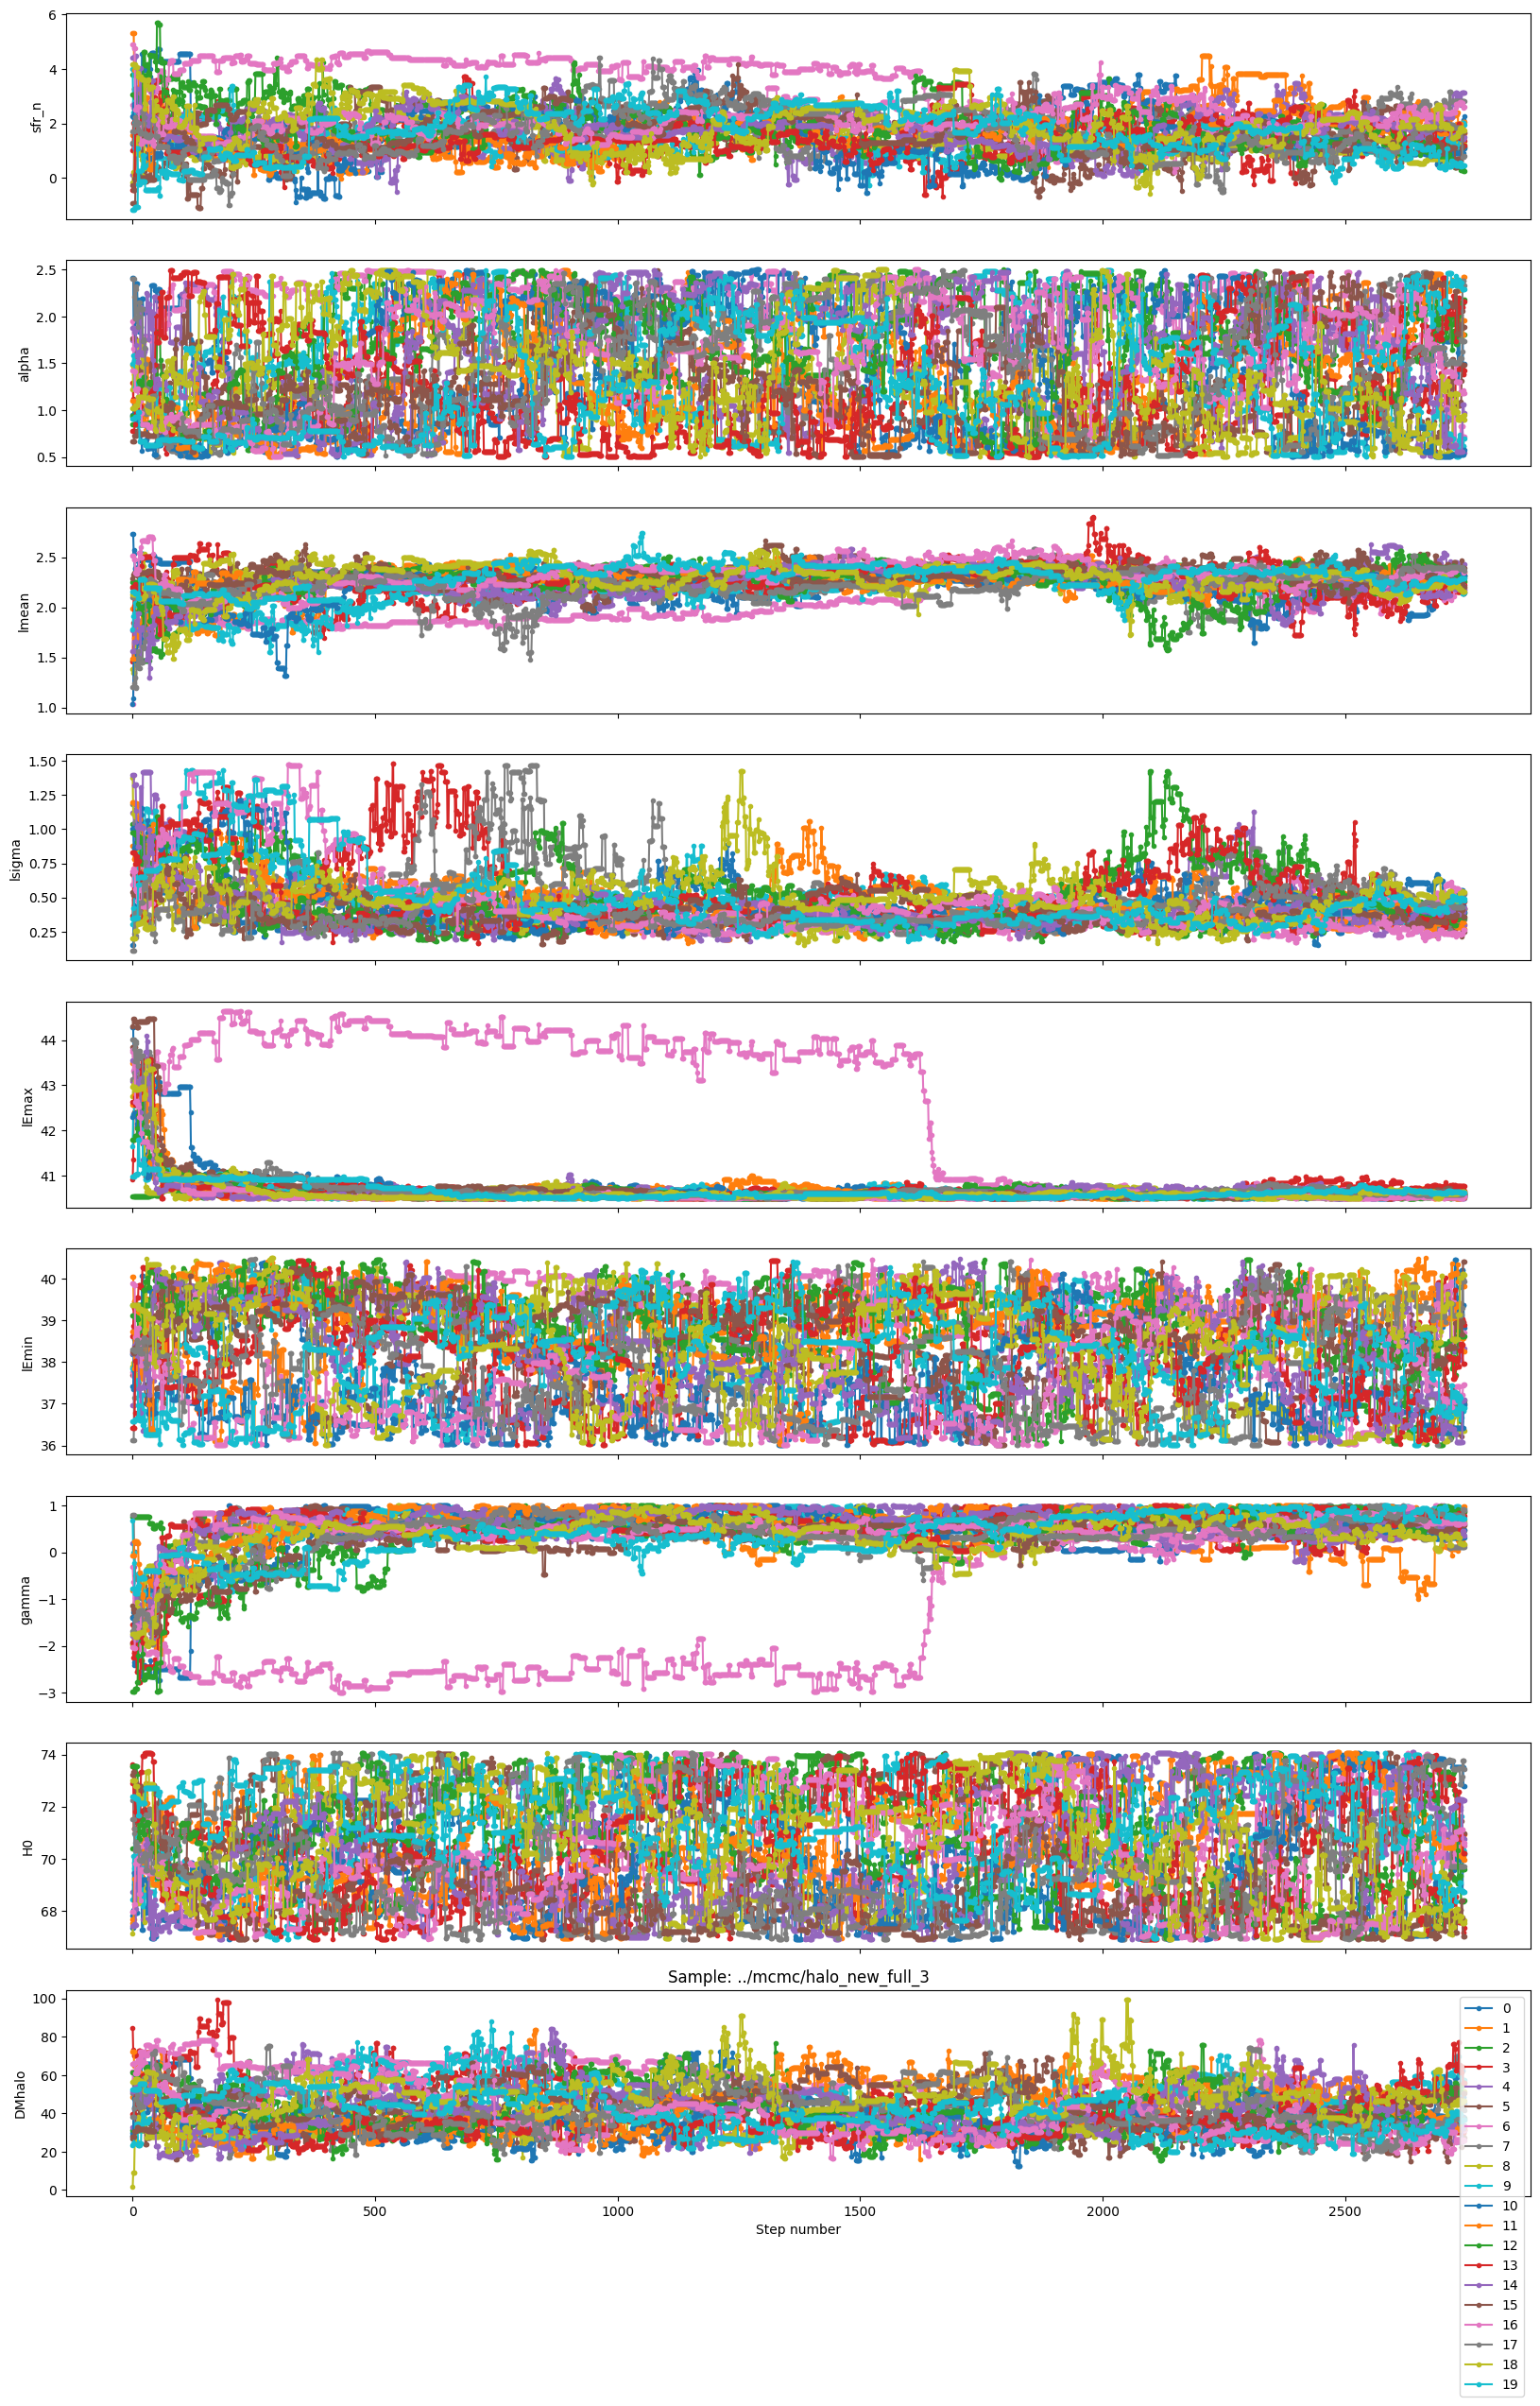

In [46]:
for j,sample in enumerate(samples):
    print(sample.shape)
    fig, axes = plt.subplots(sample.shape[2], 1, figsize=(20,30), sharex=True)
    plt.title("Sample: " + filenames[j])
    for i,ax in enumerate(axes):
        for k in range(sample.shape[1]):
            ax.plot(sample[:,k,i], '.-', label=str(k))

        ax.set_ylabel(labels[i])
    
    axes[-1].set_xlabel("Step number")
    axes[-1].legend()


# Burnin

Here we present different methods to get the burnin from https://emcee.readthedocs.io/en/stable/tutorials/autocorr/#a-more-realistic-example however we note that in actuality it is generally easier and more useful to specify burnin=200 or something similar which is done further below.

In [47]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm and acf[0] != 0:
        acf /= acf[0]

    return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def autocorr(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

# Discard walkers

- Discards any walkers that do not converge

In [48]:
# Reject walkers with bad autocorrelation values
def auto_corr_rej(samples, burnin=0):
    good_samples = []

    # Loop through each sample and generate a list of good walkers and bad walkers
    for j,sample in enumerate(samples): 
        # burnin=200
        good_walkers = []
        bad_walkers = []


        # for i in range(sample.shape[1]):
        #     # if np.all(sample[burnin:burnin+30,i,0] == sample[burnin,i,0]):
        #     if ( np.std(sample[burnin:burnin+30,i,0] ) )
        #         bad_walkers.append(i)
        #     else:
        #         good_walkers.append(i)

        # Loop through each walker in the current sample
        for i in range(sample.shape[1]):
            bad = False

            # Loop through each parameter for the walker
            for k in range(sample.shape[2]):

                # If any of the parameters have a bad autocorrelation function then set as a bad walker
                acf = autocorr_func_1d(sample[burnin:,i,k], norm=False)
                if np.max(acf) < 1e-10:
                    bad = True
                    break

            if bad:
                bad_walkers.append(i)
            else:
                good_walkers.append(i)
            
            # fig = plt.figure()
            # plt.title(str(j) + ", " + str(i))
            # ax = fig.add_subplot(1,1,1)
            # ax.plot(acf)

        print("Discarded walkers for sample " + str(j) + ": " + str(bad_walkers))

        # Add the new sample with the bad walkers discarded to the good_samples list
        good_samples.append(sample[burnin:,good_walkers,:])

    return good_samples

# Reject walkers with small standard deviations
def std_rej(samples, burnin=0):
    good_samples = []

    if not type(burnin) == list:
        burnin = [burnin for i in range(len(samples))]

    # Loop through each sample
    for i, sample in enumerate(samples):
        bad_walkers = []
        good_walkers = []

        # For each parameter
        for k in range(sample.shape[2]):
            sd = []

            # Loop through every walker and get a list of the standard deviations
            for j in range(sample.shape[1]):
                sd.append(np.std(sample[burnin[i]:burnin[i]+100,j,k]))
            
            # Normalise standard deviation
            sd = sd / np.max(sd)

            # Flag any walkers with standard deviations less than 1e-2
            bad_walkers = [] # np.flatnonzero(sd < 1e-2)
            temp = []
            for m in range(len(sd)):
                if sd[m] < 1e-2:
                    bad_walkers.append(m)

        bad_walkers.append(6)
        # bad_walkers.append(15)
        # bad_walkers.append(5)
        # bad_walkers.append(8)
        bad_walkers = np.unique(np.array(bad_walkers))

        print("Discarded walkers for sample " + str(i) + ": " + str(bad_walkers))
        for l in range(sample.shape[1]):
            if l not in bad_walkers:
                good_walkers.append(l)

        # Add the new sample with the bad walkers discarded to the good_samples list
        good_samples.append(sample[:,good_walkers,:])
    
    return good_samples

In [49]:
good_samples = std_rej(samples, burnin=150)
# good_samples = samples
# _ = auto_corr_rej(samples, burnin=0)

Discarded walkers for sample 0: [6]


Plot the autocorrelation time to estimate the burnin once the bad walkers have been discarded.

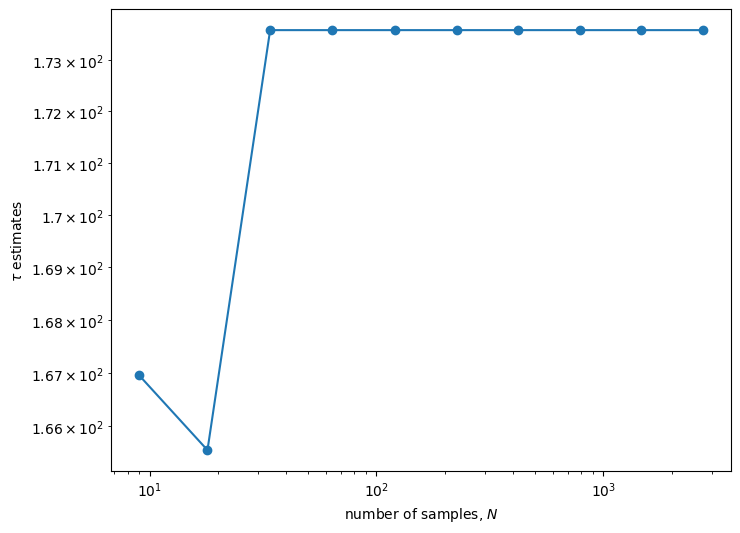

In [50]:
burnin = []
for sample in good_samples:
    # Compute the estimators for a few different chain lengths
    N = np.exp(np.linspace(np.log(10), np.log(sample.shape[0]), 10)).astype(int)
    new = np.empty(len(N))
    for i, n in enumerate(N):
        new[i] = autocorr(sample[:, :n, 0].T)

    # Plot the comparisons
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.loglog(N, new, "o-", label="new")
    ylim = ax.get_ylim()
    ax.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
    ax.set_ylim(ylim)
    ax.set_xlabel("number of samples, $N$")
    ax.set_ylabel(r"$\tau$ estimates")
    # ax.legend(fontsize=14);

    burnin.append(int(1.5*new[-1]))

In [51]:
# for j,sample in enumerate(good_samples):
#     fig, axes = plt.subplots(sample.shape[2], 1, figsize=(20,30), sharex=True)
#     plt.title("Sample: " + filenames[j])
#     for i,ax in enumerate(axes):
#         for k in range(sample.shape[1]):
#             ax.plot(sample[burnin[j]:,k,i], '.-', label=str(k))

#         ax.set_ylabel(labels[i])
    
#     axes[-1].set_xlabel("Step number")
#     axes[-1].legend()


# Implement burnin and change priors

- Changes prior to discard samples outside the specified prior range
- Implements the burnin using either the predefined burnin or a constant specified

In [52]:
# Enforce more restrictive priors on a parameter
def change_priors(sample, param_num, max=np.inf, min=-np.inf):

    condition = np.logical_and(sample[:,param_num] > min, sample[:,param_num] < max)
    good_idxs = np.flatnonzero(condition)

    return sample[good_idxs, :]

In [61]:
# Get the final sample without burnin and without bad walkers
final_sample = [[] for i in range(samples[0].shape[2])]

# print(burnin)
burnin = (np.ones(len(good_samples)) * 750).astype(int)
print(burnin)

for j,sample in enumerate(good_samples):
    for i in range(sample.shape[2]):
        final_sample[i].append(sample[burnin[j]:,:,i].flatten())
final_sample = np.array([np.hstack(final_sample[i]) for i in range(len(final_sample))]).T

# final_sample = change_priors(final_sample, 5, min=38)
# final_sample = change_priors(final_sample, 7, max=110.0)
# final_sample = change_priors(final_sample, 9, max=80.0)
# final_sample = change_priors(final_sample, 1, max=1.0, min=-3.5)

print(final_sample.shape)


[750]
(37924, 9)


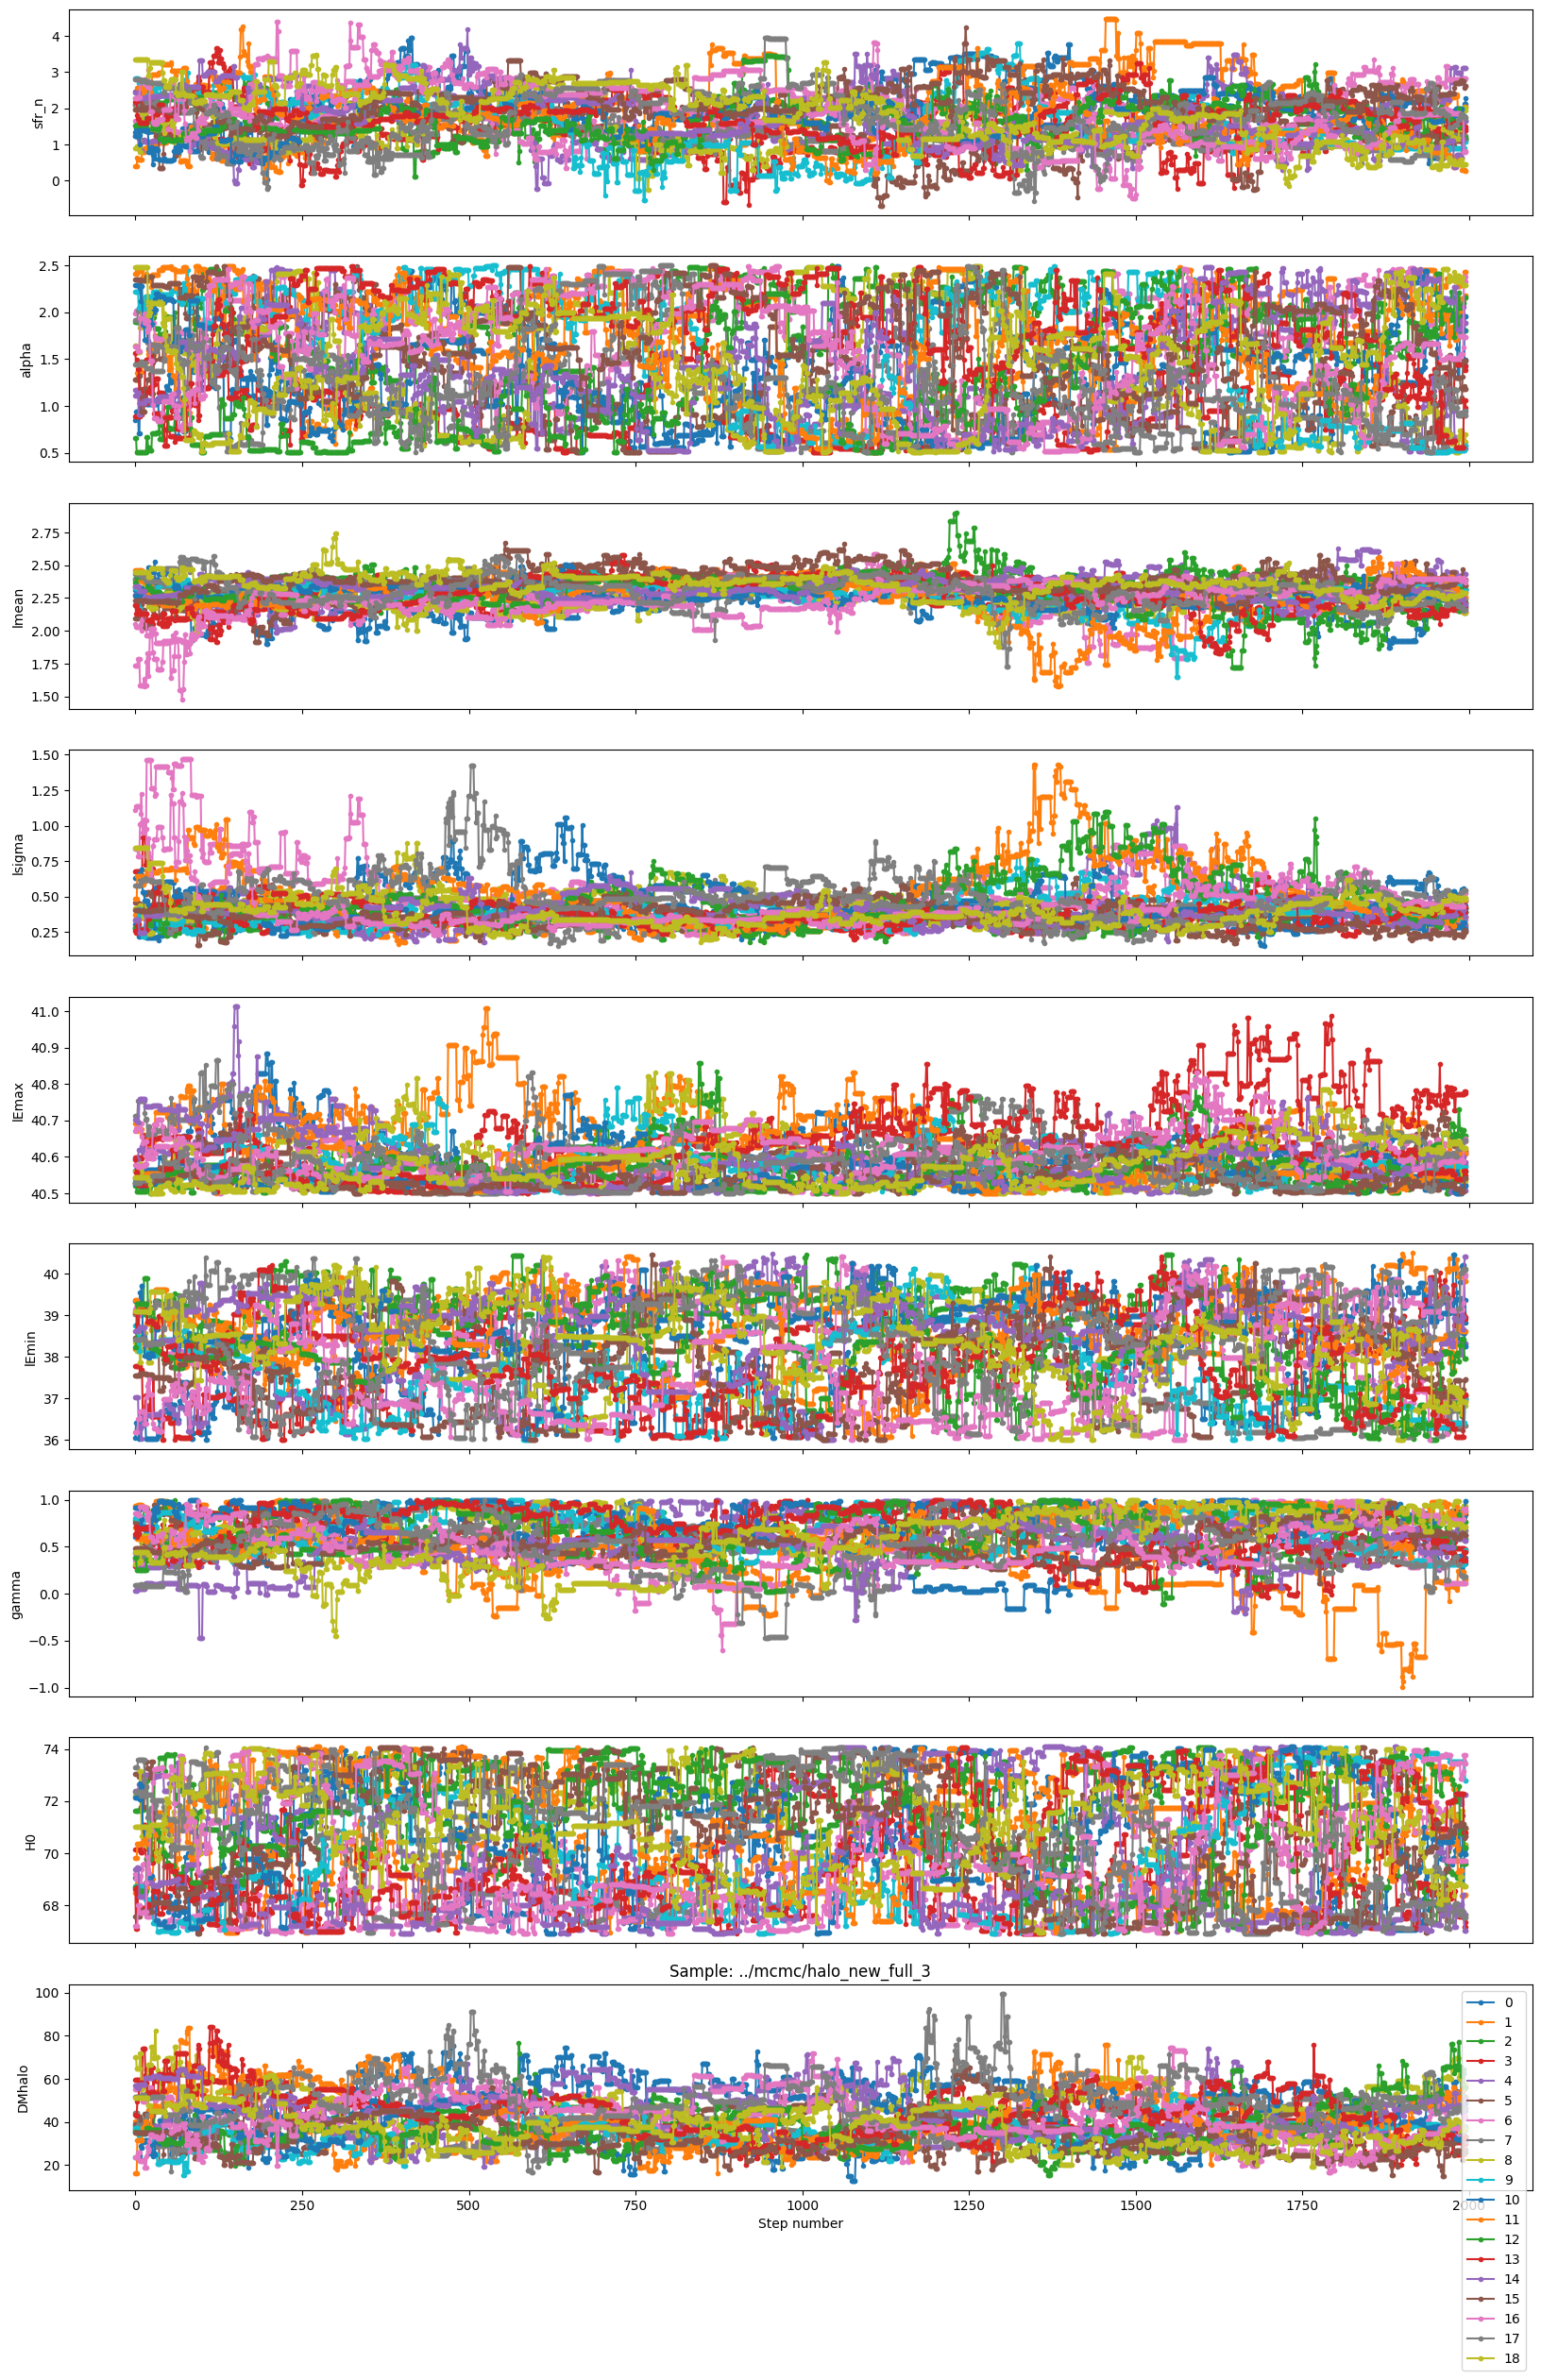

In [62]:
for j,sample in enumerate(good_samples):
    fig, axes = plt.subplots(sample.shape[2], 1, figsize=(20,30), sharex=True)
    plt.title("Sample: " + filenames[j])
    for i,ax in enumerate(axes):
        for k in range(sample.shape[1]):
            ax.plot(sample[burnin[j]:,k,i], '.-', label=str(k))

        ax.set_ylabel(labels[i])
    
    axes[-1].set_xlabel("Step number")
    axes[-1].legend()


# Cornerplot

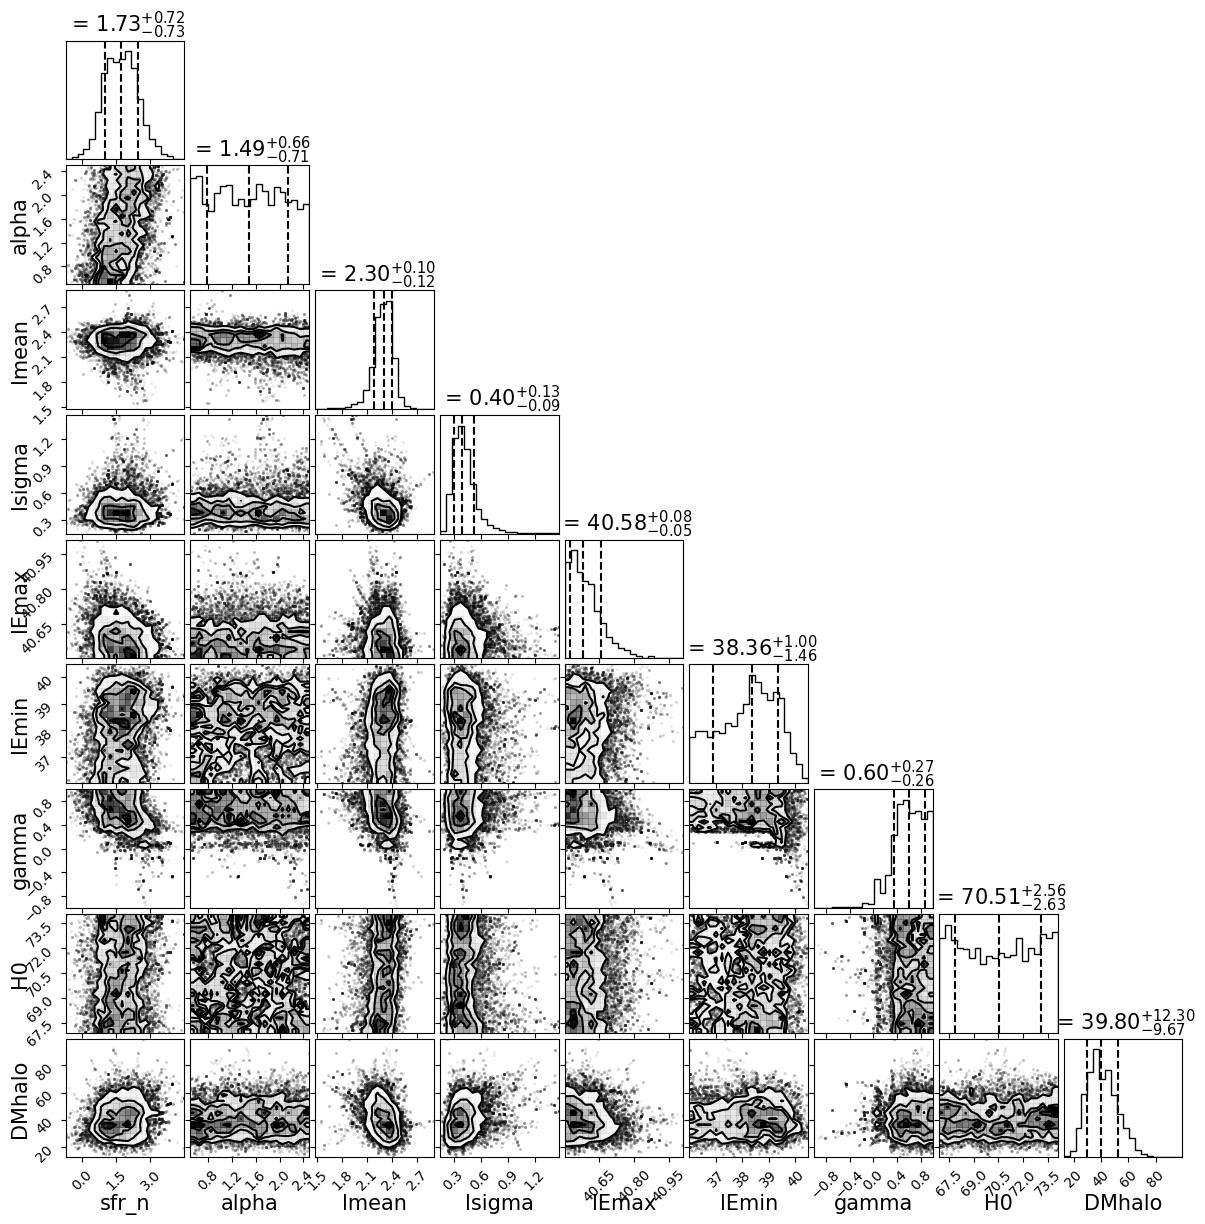

In [63]:

lmean = 2.27
DMhalo = np.log10(50.0)
param_dict={'logF': np.log10(0.32), 'sfr_n': 1.13, 'alpha': 1.5, 'lmean': lmean, 'lsigma': 0.55, 
            'lEmax': 41.26, 'lEmin': 39.5, 'gamma': -0.95, 'DMhalo': DMhalo, 'H0': 73,
            'min_lat': None}

# truths = [param_dict[param] for param in labels]
fig = plt.figure(figsize=(12,12))

titles = ['' for i in range(final_sample.shape[1])]
corner.corner(final_sample,labels=labels, show_titles=True, titles=titles, 
              fig=fig,title_kwargs={"fontsize": 15},label_kwargs={"fontsize": 15}, 
              quantiles=[0.16,0.5,0.84], truths=None);

# plt.savefig("MCMC_halo_fit.pdf")

# Point estimates

- Use finer histogram binning than the corner plot
- Obtain point estimates and confidence intervals using median / mode

sfr_n: 1.7294049204398037 (-0.7267863982141172/+0.7155218334745426)
alpha: 1.4859524003747502 (-0.7069579096142913/+0.6609603512903999)
lmean: 2.3007428869522486 (-0.11582424585380524/+0.09873516214714995)
lsigma: 0.396300210604263 (-0.09180167012510826/+0.13351824998067863)
lEmax: 40.578551786703116 (-0.0534217630509346/+0.07821872609331137)
lEmin: 38.35533894604933 (-1.4552674580358413/+0.9999025447220333)
gamma: 0.6032500201815869 (-0.263219026035517/+0.26902171988238877)
H0: 70.51322705185869 (-2.6270897052830264/+2.5602268097213283)


DMhalo: 39.800465306883666 (-9.672499163916001/+12.304530308080217)
{'sfr_n': 1.7294049204398037, 'alpha': 1.4859524003747502, 'lmean': 2.3007428869522486, 'lsigma': 0.396300210604263, 'lEmax': 40.578551786703116, 'lEmin': 38.35533894604933, 'gamma': 0.6032500201815869, 'H0': 70.51322705185869, 'DMhalo': 39.800465306883666}


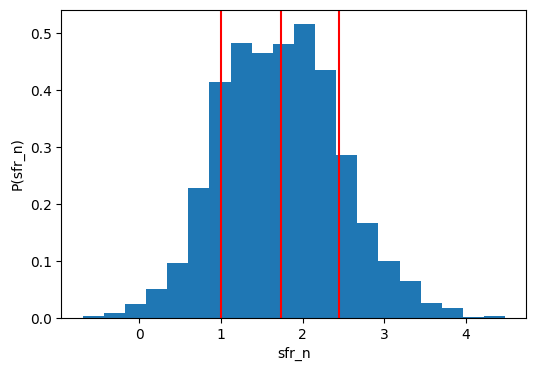

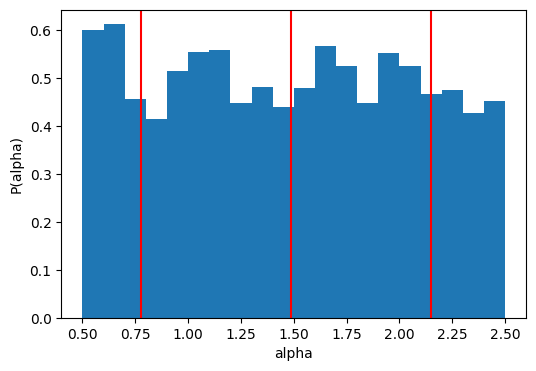

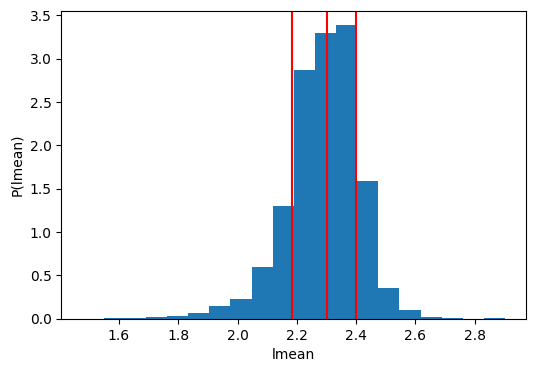

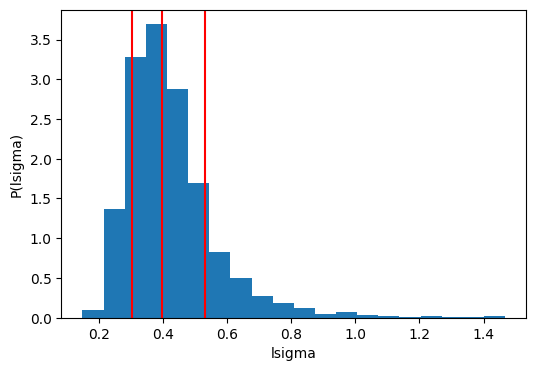

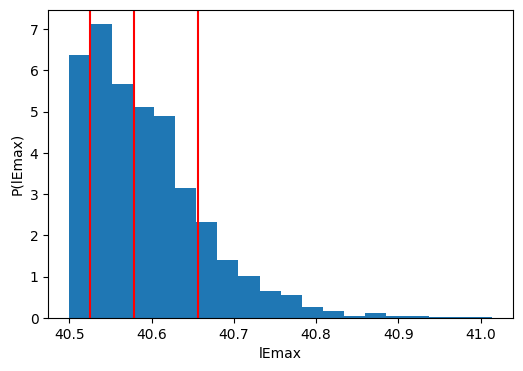

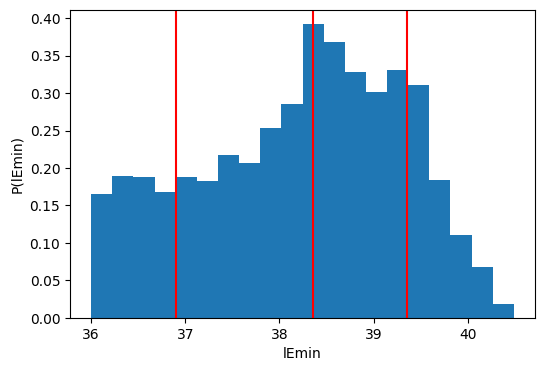

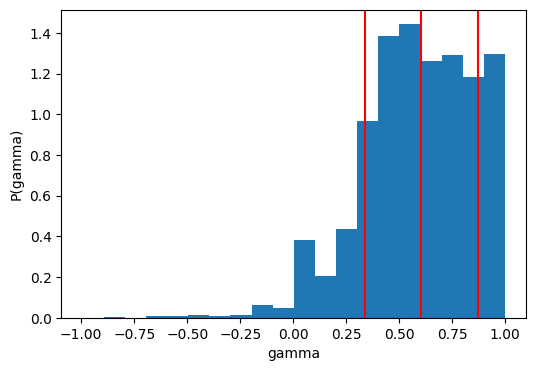

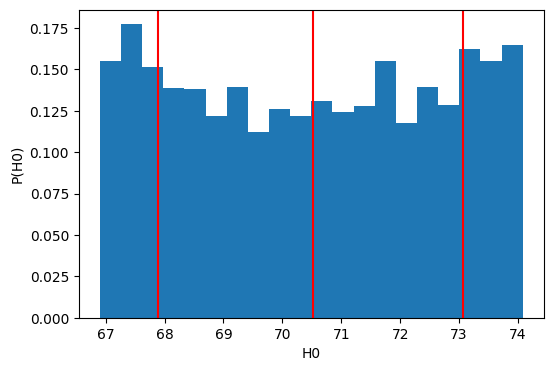

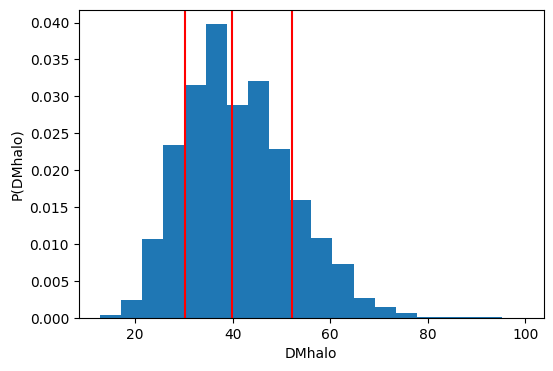

In [64]:
nBins = 20
win_len = int(nBins/10)
CL = 0.68

best_fit = {}

for i in range(len(labels)):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(1,1,1)
    hist, bin_edges, _ = ax.hist(final_sample[:,i], bins=nBins, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    bins = -np.diff(bin_edges)/2.0 + bin_edges[1:]

    ax.set_xlabel(labels[i])
    ax.set_ylabel("P("+labels[i]+")")

    # Use mode ordered
    # ordered_idxs = np.argsort(hist)

    # sum = hist[ordered_idxs[0]] * bin_width
    # j = 1
    # while(sum < 1-CL):
    #     sum += hist[ordered_idxs[j]] * bin_width
    #     j = j+1

    # best = bins[ordered_idxs[-1]]
    # lower = bins[np.min(ordered_idxs[j:])]
    # upper = bins[np.max(ordered_idxs[j:])]

    # Use median
    best = np.quantile(final_sample[:,i], 0.5)
    # best = bins[np.argmax(hist)]
    lower = np.quantile(final_sample[:,i], 0.16)
    upper = np.quantile(final_sample[:,i], 0.84)

    best_fit[labels[i]] = best
    u_lower = best - lower
    u_upper = upper - best
    ax.axvline(lower, color='r')
    ax.axvline(best, color='r')
    ax.axvline(upper, color='r')
    # print(labels[i] + ": " + str(best) + " (-" + str(u_lower) + "/+" + str(u_upper) + ")")
    print(rf'{labels[i]}: {best} (-{u_lower}/+{u_upper})')

print(best_fit)



In [65]:
import scipy.stats as st

In [66]:
# nsamps = np.linspace(3, np.log10(final_sample.shape[0]/10), 30)
# nsamps = [int(10**x) for x in nsamps]
# print("Number of samps: " + str(nsamps))

# for i in range(len(labels)):
#     # nsamps = []
#     std = []
#     for j in range(len(nsamps)):
#         best = []
#         nruns = int(final_sample.shape[0] / nsamps[j])
#         for k in range(nruns):
#             # best.append(np.quantile(final_sample[nsamps[j]*k:nsamps[j]*(k+1),i], 0.5))
#             step = int(final_sample.shape[0]/nsamps[j])
#             best.append(np.quantile(final_sample[k::step,i], 0.5))
#         std.append(np.std(best))

#     # print(labels[i] + ": " + str(std))

#     line = st.linregress(np.log10(nsamps),np.log10(std))
#     x = np.linspace(nsamps[0], nsamps[-1], 50)
#     y = 1/np.sqrt(x)
#     y = y / y[0] * std[0]
#     y = 10**(line.slope*np.log10(x) + line.intercept)
#     # print(line.slope)
#     print(labels[i] + ": " + str(10**(line.slope*np.log10(final_sample.shape[0]) + line.intercept)))
#     print(str(line.slope))
#     fig = plt.figure(figsize=(6,4))
#     ax = fig.add_subplot(1,1,1)

#     ax.plot(nsamps, std)
#     ax.loglog(x,y)
#     ax.set_xlabel("Number of samples")
#     ax.set_ylabel("Standard deviation")
#     ax.set_title(labels[i])

# Load surveys and grids

- Loads the surveys and grids with the best fit parameters from above.
- Plots P(DM) and DMEG weights for each FRB

In [67]:
s_names = [
    # "FAST2",
    # "FAST2_old"
    # "DSA",
    "FAST", 
    # "CRAFT_class_I_and_II", 
    # "private_CRAFT_ICS_892_14", 
    # "private_CRAFT_ICS_1300_14", 
    # "private_CRAFT_ICS_1632_14", 
    # "parkes_mb_class_I_and_II"
]
# rs_names = ["CHIME/CHIME_decbin_0_of_6",
#             "CHIME/CHIME_decbin_1_of_6",
#             "CHIME/CHIME_decbin_2_of_6",
#             "CHIME/CHIME_decbin_3_of_6",
#             "CHIME/CHIME_decbin_4_of_6",
#             "CHIME/CHIME_decbin_5_of_6"]
rs_names = []

state = parameters.State()
state.set_astropy_cosmo(Planck18) 
# state.update_params(best_fit)
# state.update_param('luminosity_function', 2)
# state.update_param('alpha_method', 0)
# state.update_param('sfr_n', 1.36)
# state.update_param('alpha', 1.5)
# state.update_param('lmean', 1.97)
# state.update_param('lsigma', 0.92)
# state.update_param('lEmax', 41.3)
# state.update_param('gamma', -0.63)
# state.update_param('H0', 70.0)
# state.update_param('DMhalo', 50.0)

if len(s_names) != 0:
    surveys, grids = loading.surveys_and_grids(survey_names = s_names, init_state=state, repeaters=False, nz=500, ndm=1400)
else:
    surveys = []
    grids = []

if len(rs_names) != 0:
    rep_surveys, rep_grids = loading.surveys_and_grids(survey_names = rs_names, init_state=state, repeaters=True, nz=500, ndm=1400)
    for s,g in zip(rep_surveys, rep_grids):
        surveys.append(s)
        grids.append(g)

Loading survey: FAST
Loading survey: FAST from FAST.ecsv
Using minimum galactic latitude of 30. Excluding 7 FRBs
2
Loaded FRB info
FRB survey sucessfully initialised with  2  FRBs starting from 0
Initialised surveys
Initialised grids


FAST - expected, observed: 9.000000000000002, 9


AttributeError: 'Grid' object has no attribute 'Rc'

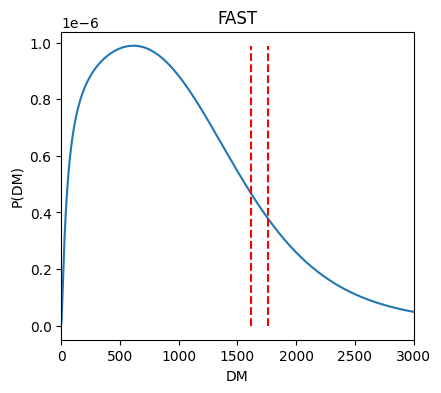

In [68]:
newC, llc = it.minimise_const_only(None, grids, surveys)
llsum = 0
for s,g in zip(surveys, grids):

    g.state.FRBdemo.lC = newC
    
    # Calc pdm
    rates=g.rates
    dmvals=g.dmvals
    pdm=np.sum(rates,axis=0)

    # # Calc psnr
    # min = s.SNRTHRESHs[0]
    # max = np.max(s.SNRs)
    # snrs = np.linspace(min,max, 50)
    # psnr = get_psnr(snrs, s, g)
    
    # Plot pdm + snr
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,2,1)
    ax.set_title(s.name)
    ax.set_xlabel("DM")
    ax.set_ylabel("P(DM)")
    ax.set_xlim(xmax=3000)
    ax.plot(dmvals, pdm)
    ax.vlines(s.DMEGs, np.zeros(len(s.DMs)), np.max(pdm)*np.ones(len(s.DMs)), ls='--', colors='r')
    
    # ax = fig.add_subplot(1,2,2)
    # ax.set_xlabel("log SNR")
    # ax.set_ylabel("log P(SNR)")
    # ax.plot(np.log10(snrs), np.log10(psnr))
    # ax.vlines(np.log10(s.SNRs), np.min(np.log10(psnr))*np.ones(len(s.SNRs)), np.max(np.log10(psnr))*np.ones(len(s.SNRs)), ls='--', colors='r')

    # Get expected and observed
    expected=it.CalculateIntegral(g.rates,s)
    expected *= 10**g.state.FRBdemo.lC
    observed=s.NORM_FRB

    print(s.name + " - expected, observed: " + str(expected) + ", " + str(observed))

    llsum += it.get_log_likelihood(g,s,Pn=True)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

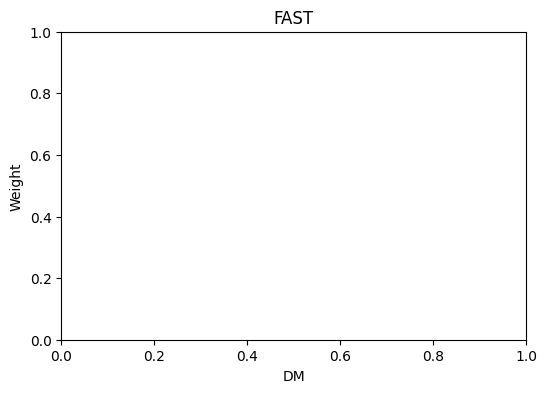

In [ ]:
uDMGs = 0.5
# DMhalo = 100.0

fig = plt.figure(figsize=(6,4*len(s_names)))

for j,(s,g) in enumerate(zip(surveys, grids)):
    ax = fig.add_subplot(len(surveys),1,j+1)
    plt.title(s.name)
    ax.set_xlabel('DM')
    ax.set_ylabel('Weight')

    # s.DMhalo = DMhalo
    # s.init_DMEG(DMhalo)

    dmvals=g.dmvals
    DMobs=s.DMEGs

        # calc_DMG_weights(DMEGs, DMhalos, DM_ISMs, dmvals, sigma_ISM=0.5, sigma_halo=15.0, percent_ISM=True)
    dm_weights, iweights = it.calc_DMG_weights(DMobs, s.DMhalos, s.DMGs, dmvals, uDMGs)

    pdm = np.sum(g.rates, axis=0)
    pdm = pdm / np.max(pdm) * np.max(dm_weights[0])

    for i in range(len(DMobs)):
        ax.plot(dmvals[iweights[i]], dm_weights[i], '.-', label=s.frbs["TNS"][i] + " " + str(s.DMGs[i]))

    # ax.plot(dmvals, pdm) # Upper limit is not correct because grid has not been updated so efficiencies have not been recalc'd
    ax.set_xlim(right=3000)
    # ax.legend()
    